In [36]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

In [2]:
#Set the county name
co_name = 'WAKE'

## Get data
* Census block features
* Voter registration data, linked with lat/longs (via state address file)

In [3]:
#Get county block data as geodataframe
gdfBlocksAll = gpd.read_file('../data/OUTPUT/{0}/{0}_blocks.shp'.format(co_name))
gdfBlocksAll.drop(columns=['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE', 'BLOCKID10',
                           'PARTFLG', 'HOUSING10', 'POP10','P010001', 'P010004', 'PctBlack18'],
                  axis=1,inplace=True)
gdfBlocksAll.columns

Index(['P003001', 'P003003', 'GEOID10', 'PctBlack', 'BlackHH', 'geometry'], dtype='object')

In [4]:
#Get voter points as dataframe
dfVoterPoints_All = pd.read_csv('../data/OUTPUT/{0}/{0}_voter_points.csv'.format(co_name))
dfVoterPoints_All = dfVoterPoints_All[['Race','MECE','ncid','latitude','longitude']]
dfVoterPoints_All.columns

Index(['Race', 'MECE', 'ncid', 'latitude', 'longitude'], dtype='object')

## Filter voter data and convert to spatial features

In [5]:
#Subset only black voter points
dfVoterPoints_Black = dfVoterPoints_All.query('Race == "B"').reset_index()
dfVoterPoints_Black.shape

(31971, 6)

In [6]:
#Convert voter points to geodataframe
geom = [Point(xy) for xy in zip(dfVoterPoints_Black.longitude,dfVoterPoints_Black.latitude)]
gdfVoterPoints = gpd.GeoDataFrame(dfVoterPoints_Black,geometry=geom,crs={'init':'epsg:4269'})
gdfVoterPoints.shape

(31971, 7)

## Tag voter features with census block ID

In [7]:
#Append voter points with Census Block ID via spatial join
gdfVoterPoints = gpd.sjoin(gdfVoterPoints,gdfBlocksAll[['GEOID10','geometry']],how='left',op='within')
gdfVoterPoints.columns

Index(['index', 'Race', 'MECE', 'ncid', 'latitude', 'longitude', 'geometry',
       'index_right', 'GEOID10'],
      dtype='object')

## Tally black voter MECE scores by census block

In [8]:
#Tally block MECE scores
dfBlockMECE = (gdfVoterPoints.pivot_table(
    index='GEOID10',
    columns='MECE',
    aggfunc={'ncid':'count'})
           .fillna(0)               # Set NaNs to zero
           .droplevel(0,axis=1)     # Drop multi-index
           .reset_index())          # Reset row index
# Rename columns
dfBlockMECE.columns=['GEOID10','MECE1','MECE2','MECE3','MECE4','MECE5']
# Convert MECE counts to integers
mece_cols = ['MECE1','MECE2','MECE3','MECE4','MECE5']
dfBlockMECE[mece_cols]=dfBlockMECE[mece_cols].astype('int')
# Compute total column
dfBlockMECE['Total']=dfBlockMECE[['MECE1','MECE2','MECE3','MECE4','MECE5']].sum(axis=1)

In [9]:
#Join MECE scores to census block features
gdfBlocksAll = gdfBlocksAll.merge(dfBlockMECE,on='GEOID10')

In [10]:
#Visualize results
#gdfBlocksAll.plot('Total',figsize=(10,10),cmap='YlGnBu');

## Calcualte turfs
#### Isolate blocks that are at least 50% black 

In [11]:
#Subset blocks that have >= 50% black households
gdfBlocks = gdfBlocksAll.query('PctBlack >= 50').reset_index().drop('index',axis=1)

#### From those, save blocks with > 50 black households to "keeper set #1"

In [21]:
#Save blocks having > 50 black households to a separate geodataframe
gdf_Set1 = gdfBlocks.query('BlackHH >= 50').reset_index().drop('index',axis=1)
gdf_Set1['OrgType'] = 'OriginalBlock'
gdf_Set1.drop(['P003001','P003003','GEOID10'],axis=1,inplace=True)

#### Create composite turfs from remaining blocks (those with fewer than 50 BHH)

In [13]:
#Save blocks having < 50 BHH to new geodataframe for aggregating
gdf_ToProcess = gdfBlocks.query('BlackHH < 50').reset_index().drop('index',axis=1)

In [14]:
#Create clusters by merging adjacent blocks into block clusters
gdfClusters = gpd.GeoDataFrame(geometry=list(gdf_ToProcess.unary_union))
gdfClusters['ClusterID'] = gdfClusters.index
gdfClusters.crs = gdf_ToProcess.crs
print("{} unique clusters created".format(gdfClusters.shape[0]))

75 unique clusters created


In [15]:
#Assign cluster IDs to each "to process" blocks
gdf_ToProcess = (gpd
                 .sjoin(gdf_ToProcess,gdfClusters[['ClusterID','geometry']],how='left',op='within')
                 .drop('index_right',axis=1))

In [16]:
#Dissolve blocks on Cluster ID and tally sums
gdfClusters2 = gdf_ToProcess.dissolve(by='ClusterID',aggfunc='sum')

In [17]:
#Update pctBlack field
gdfClusters2['PctBlack'] = gdfClusters2['P003003'] / gdfClusters2['P003001'] * 100

In [18]:
#Retain only block clusters with > 50 BHH; others are impractical
gdfClusters2 = gdfClusters2.query('BlackHH >= 50')

In [23]:
#Save clustered blocks with < 100 Black HH to Set_2
gdf_Set2 = gdfClusters2.query('BlackHH <= 100').reset_index().drop(['ClusterID','P003001','P003003'],axis=1)
gdf_Set2['OrgType'] = 'Clustered'
gdf_Set2.head()

,geometry,PctBlack,BlackHH,MECE1,MECE2,MECE3,MECE4,MECE5,Total,OrgType
0,"POLYGON ((-78.570272 35.757264, -78.570391 35....",66.153846,67,44,97,40,11,40,232,Clustered
1,"POLYGON ((-78.597206 35.686495, -78.598141 35....",63.333333,55,7,83,24,11,16,141,Clustered
2,"POLYGON ((-78.83646399999999 35.683734, -78.83...",80.694981,70,23,63,22,7,15,130,Clustered
3,"POLYGON ((-78.79899399999999 35.663849, -78.79...",81.290323,58,4,47,18,10,15,94,Clustered
4,"POLYGON ((-78.53317699999999 35.736415, -78.53...",68.506494,65,23,35,19,13,27,117,Clustered


In [22]:
gdf_Set1.head()

,PctBlack,BlackHH,geometry,MECE1,MECE2,MECE3,MECE4,MECE5,Total,OrgType
0,59.383754,70,"POLYGON ((-78.33744 35.821984, -78.337457 35.8...",0,49,33,14,23,119,OriginalBlock
1,72.307692,53,"POLYGON ((-78.572563 35.811895, -78.572035 35....",1,0,3,0,2,6,OriginalBlock
2,52.238806,63,"POLYGON ((-78.65722199999999 35.782297, -78.65...",0,0,2,1,8,11,OriginalBlock
3,76.585366,137,"POLYGON ((-78.60934899999999 35.75329, -78.609...",18,56,65,25,82,246,OriginalBlock
4,79.354839,59,"POLYGON ((-78.65531299999999 35.87068, -78.654...",0,1,0,0,2,3,OriginalBlock


In [24]:
#Step 4e. For clusters that are too big (> 100 Black HH), cluster incrementally
#  so that clusters have up to 100 Black HH. These will be saved as gdf_Org3

#-> Get a list of Cluster IDs for block clusters with more than 100 BHH;
#   we'll cluster individual blocks with these IDs until BHH >= 100
clusterIDs = gdfClusters2.query('BlackHH > 100').index.unique()

In [25]:
#Iterate through each clusterID
gdfs = []
for clusterID in clusterIDs:
    #Get all the blocks in the selected cluster
    gdfBlksAll = gdf_ToProcess.query('ClusterID == {}'.format(clusterID)).reset_index()
    #Assign the X coordinate, used to select the first feature in a sub-cluster
    gdfBlksAll['X'] = gdfBlksAll.geometry.centroid.x
    #Set all blocks to "unclaimed"
    gdfBlksAll['claimed'] = 0
    #Determine how many blocks are unclaimed
    unclaimedCount = gdfBlksAll.query('claimed == 0')['X'].count()
    #Initialize the loop catch variable
    stopLoop = 0 
    #Run until all blocks have been "claimed"
    while unclaimedCount > 0:
        
        #Extract all unclaimed blocks
        gdfBlks = gdfBlksAll[gdfBlksAll.claimed == 0].reset_index()

        #Get the initial block (the western most one); get its BHH and geometry
        gdfBlock = gdfBlks[gdfBlks.X == gdfBlks.X.min()]
        BHH = gdfBlock.BlackHH.sum()
        geom = gdfBlock.geometry.unary_union
        
        #Expand the geometry until 100 BHH are found
        stopLoop2 = 0 #Loop break check
        while BHH < 100:
            #Select unclaimed blocks that within the area
            gdfNbrs = gdfBlksAll[(gdfBlksAll.touches(geom))]
            gdfBoth = pd.concat((gdfBlock,gdfNbrs),axis='rows',sort=False)
            gdfBlock = gdfBoth.copy(deep=True)
            #Tally the BHHs in the area and update the area shape
            BHH = gdfBoth.BlackHH.sum()
            geom = gdfBoth.geometry.unary_union
            #Catch if run 100 times without getting to 100 BHH
            stopLoop2 += 1
            if stopLoop2 > 100: 
                print("BHH never reached 100")
                break
                
        #Extract features intersecting the geometry to a new dataframe
        gdfSelect = (gdfBlksAll[(gdfBlksAll.centroid.within(geom)) & 
                                (gdfBlksAll.claimed == 0) 
                               ]
                 .reset_index()
                 .dissolve(by='ClusterID', aggfunc='sum')
                 .drop(['level_0','index','X'],axis=1)
                )
        
        #Set all features intersecting the shape as "claimed"
        gdfBlksAll.loc[gdfBlksAll.geometry.centroid.within(geom),'claimed'] = 1
        unclaimedCount = gdfBlksAll.query('claimed == 0')['X'].count()

        #Add the dataframe to the list of datarames
        gdfs.append(gdfSelect[gdfSelect['BlackHH'] >= 50])    
        
        #Stop the loop if run for over 100 iterations
        stopLoop += 1
        if stopLoop > 100: break
    

In [32]:
#-> Concat these to a new geodataframe, update pct fields, and add Org ID and types
print("    ...completing creating on new clusters: 'Org3'")
gdf_Set3= pd.concat(gdfs,sort=False)
gdf_Set3['PctBlack'] = gdf_Set3['P003003'] / gdf_Set3['P003001'] * 100
gdf_Set3['OrgType'] = 'block aggregate'
gdf_Set3.drop(['claimed','P003001','P003003'],axis=1,inplace=True)

    ...completing creating on new clusters: 'Org3'


In [33]:
gdf_Set3.head()

,geometry,PctBlack,BlackHH,MECE1,MECE2,MECE3,MECE4,MECE5,Total,OrgType
ClusterID,,,,,,,,,,
0,"POLYGON ((-78.60114299999999 35.695478, -78.60...",71.388102,114,12,94,32,14,31,183,block aggregate
1,"POLYGON ((-78.596716 35.727266, -78.596144 35....",82.089552,137,39,182,61,21,50,353,block aggregate
1,"POLYGON ((-78.587896 35.703238, -78.5879 35.70...",80.887372,91,6,90,23,12,27,158,block aggregate
3,POLYGON ((-78.63722199999999 35.76585499999999...,90.909091,120,15,19,32,14,56,136,block aggregate
3,"POLYGON ((-78.63465099999999 35.768262, -78.63...",91.155867,106,31,65,164,136,464,860,block aggregate


In [42]:
#--- Step 5. Merge all three keepers
print(" 5. Combining Org1, Org2, Org3 into a single feature class")
gdfAllOrgs = pd.concat((gdf_Set1, gdf_Set2, gdf_Set3),axis=0,sort=True)

 5. Combining Org1, Org2, Org3 into a single feature class


In [43]:
#--- Step 6. Assign random IDs 
print(" 6. Assigning random IDs for org units")
# 1. Compute Random Org IDs
numRows = gdfAllOrgs.shape[0]
gdfAllOrgs['Rando'] = np.random.randint(numRows,size=(numRows,1)) 
gdfAllOrgs.sort_values(by='Rando',axis=0,inplace=True)
gdfAllOrgs.reset_index(inplace=True)
gdfAllOrgs['RandomID'] = gdfAllOrgs.index + 1
gdfAllOrgs.drop(['index','RandomID','Rando'],axis=1,inplace=True)
gdfAllOrgs.head()

 6. Assigning random IDs for org units


,BlackHH,MECE1,MECE2,MECE3,MECE4,MECE5,OrgType,PctBlack,Total,geometry
0,64,1,5,3,3,10,OriginalBlock,92.380952,22,"POLYGON ((-78.613198 35.777413, -78.6133409999..."
1,84,0,0,1,0,2,OriginalBlock,64.655172,3,"POLYGON ((-78.626065 35.811292, -78.625995 35...."
2,70,23,63,22,7,15,Clustered,80.694981,130,"POLYGON ((-78.83646399999999 35.683734, -78.83..."
3,58,6,12,6,6,17,OriginalBlock,67.692308,47,"POLYGON ((-78.60553399999999 35.767493, -78.60..."
4,53,39,11,9,10,17,block aggregate,88.275862,86,"(POLYGON ((-78.61814799999999 35.777532, -78.6..."


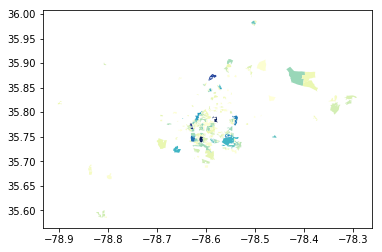

In [47]:
gdfAllOrgs.plot('BlackHH',cmap='YlGnBu');

In [ ]:
#--- Step 7. Compute org unit area, in square miles
print(" 7. Computing org unit areas (in sq miles)")

## FIX FOR PYPROJ GLITCH ##
import os, sys
env_folder = os.path.dirname(sys.executable)
os.environ['PROJ_LIB']=os.path.join(env_folder,'Library','share')

# Project data to NC State Plane (feet)   
gdfNCStatePlane = gdfAllOrgs.to_crs({'init': 'epsg:2264'})  
# Compute area, in square miles
gdfNCStatePlane['area'] = gdfNCStatePlane.geometry.area 
gdfAllOrgs['sq_miles']  =  gdfNCStatePlane['area'] / 27878400  #ft to sq mi

#--- Step 8. Tag voter data with org Unit ID
print(" 8. Tagging voter data with org unit [random] IDs")
# Spatially join org units' RandomID values to voter points
gdfVoter_org = gpd.sjoin(left_df = gdfVoter, right_df=gdfAllOrgs[['RandomID','geometry']], 
                         how='right',op='within')
# Clean up columns
gdfVoter_org.drop(columns=['index_left','Oct17', 'Nov12', 'Nov18', 'Nov17', 'Nov16',
                           'HOUSING10', 'POP10', 'P003001', 'P003003', 'P010001',
                           'P010004', 'PctBlack', 'PctBlack18', 'BlackHH'],inplace=True)
   
#--- Step 9. Add precinct and city information to org unit
print(" 9. Adding precinct and city information to org units")
# -> Create a lookup table of precincty and city for each random ID
dfLookup = (gdfVoter_org[['RandomID','precinct_abbrv','res_city_desc']].
            groupby('RandomID').
            agg(pd.Series.mode)).reset_index()
# -> Join back to the orgs dataframe
gdfAllOrgs2 = gdfAllOrgs.merge(dfLookup,on='RandomID',how='left')
# -> fix column types
gdfAllOrgs2['precinct_abbrv'] = gdfAllOrgs2['precinct_abbrv'].astype('str')
gdfAllOrgs2['res_city_desc'] = gdfAllOrgs2['res_city_desc'].astype('str')